# Value Based Order Location Anticipation

In [ ]:
import pandas as pd
from pandas.plotting import autocorrelation_plot

import geoplot as gplt
import geopandas as gpd

from sklearn.cluster import OPTICS
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import IsolationForest

from scipy import stats

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

import pmdarima as pm
from pmdarima.arima import decompose
from pmdarima.utils.visualization import decomposed_plot

import pickle

from scipy.stats import shapiro


original_df = pd.read_csv(".\\robotex4.csv")

## Initial analysis and preprocessing

In [25]:
original_df.describe()

,start_lat,start_lng,end_lat,end_lng,ride_value
count,660221.000000,660221.000000,660221.000000,660221.000000,660221.000000
mean,59.428679,24.743482,59.397394,24.724476,2.269384
std,0.021761,0.056870,1.405002,1.640483,45.110632
min,59.321557,24.505199,-37.819979,-122.453962,0.107628
25%,59.418818,24.713173,59.415233,24.707929,0.545000
50%,59.432067,24.744689,59.430705,24.744337,1.059000
75%,59.439021,24.768140,59.439259,24.773917,1.712000
max,59.566998,24.973743,61.552744,144.966110,3172.701000


In [26]:
print(original_df['start_time'].min())
print(original_df['start_time'].max())

2022-03-01 00:00:07.936317000
2022-03-28 23:59:54.440558000


In [27]:
sorted_df = original_df.sort_values(by='start_time')
sorted_df.loc[:, 'start_time'] = pd.to_datetime(sorted_df['start_time'])
sorted_df['date'] = sorted_df['start_time'].dt.date
sorted_df['hour'] = sorted_df['start_time'].dt.hour

sorted_df = sorted_df.set_index(['date', 'hour'])

size = int(len(sorted_df) * 0.75)
train, val = sorted_df[0:size], sorted_df[size:len(sorted_df)]

train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

print(f"Train min: {train['start_time'].min()}")
print(f"Train max: {train['start_time'].max()}")
print(f"Validation min: {val['start_time'].min()}")
print(f"Validation max: {val['start_time'].max()}")


Train min: 2022-03-01 00:00:07.936317
Train max: 2022-03-22 21:23:58.537626
Validation min: 2022-03-22 21:24:00.786584
Validation max: 2022-03-28 23:59:54.440558


Time is in range of about one month. So, we split the dataset into train and validation set with the last 25% as the validation dataset and the beginning of an hour as a limit.

Let's look at the disribution of rides per day. It looks like it has some seasonality and probably trend.

19    25849
18    24278
16    24225
12    23458
15    23114
22    22615
11    22035
9     21822
17    21811
5     21419
20    21274
8     20927
4     20280
2     20007
10    19756
13    19554
1     19018
21    18471
3     18068
6     17654
14    16468
7     14853
Name: day, dtype: int64

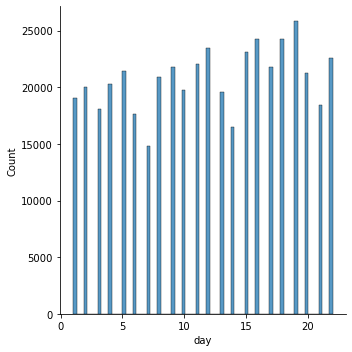

In [61]:
def initial_preprocess(df):
  df = df.dropna()
  df = df.drop_duplicates()
  df.loc[:, 'day']  = df['start_time'].dt.day
  return df

train = initial_preprocess(train)

sns.displot(train['day'])
train['day'].value_counts()

'start_lat' and 'start_lng' look normaly distributed and looks like they don't have that many outliers. To check it better it would be nice to have service map area of Bolt in Tallinn.

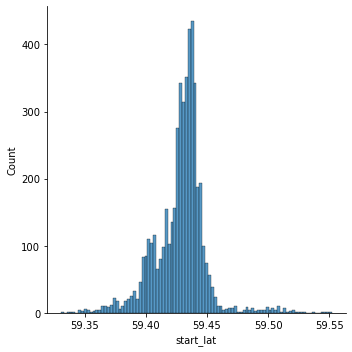

In [29]:
sns.displot(train['start_lat'].sample(frac=0.01))

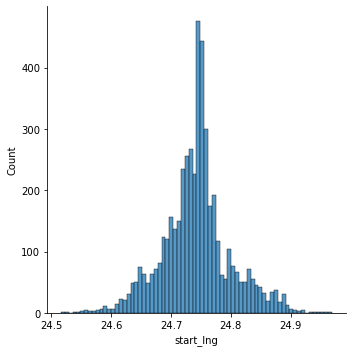

In [30]:
sns.displot(train['start_lng'].sample(frac=0.01))

<AxesSubplot:>

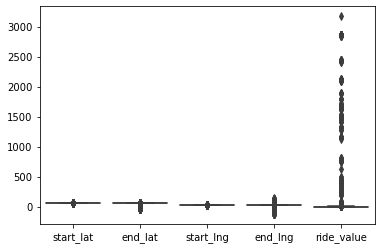

In [31]:
sns.boxplot(data=train[['start_lat', 'end_lat',
                    'start_lng', 'end_lng',
                    'ride_value']])


Fields 'end_lat', 'end_lng' and 'ride_value' clearly have outliers.

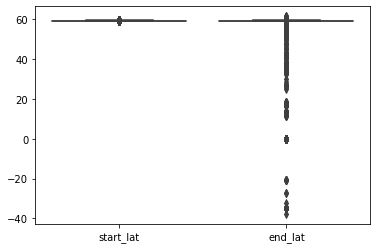

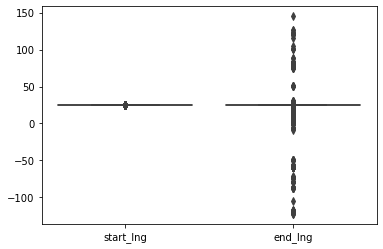

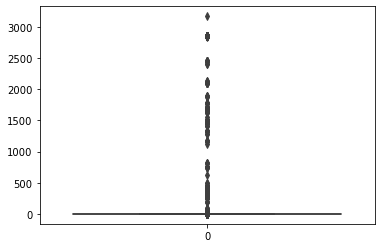

In [32]:
def boxplot_data(df):
  plt.figure()
  sns.boxplot(data=df[['start_lat', 'end_lat']])
  plt.figure()
  sns.boxplot(data=df[['start_lng', 'end_lng']])
  plt.figure()
  sns.boxplot(data=df['ride_value'])

boxplot_data(train)

In order not to analyse each field separatly let's use isolation forest to clean outliers.
The result isn't perfect by okay for baseline model.

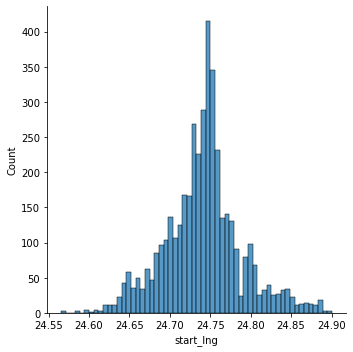

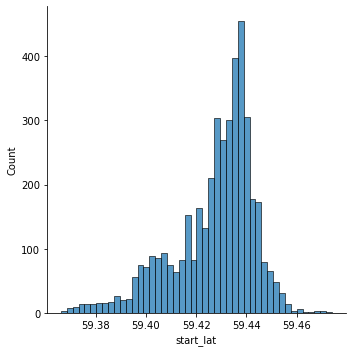

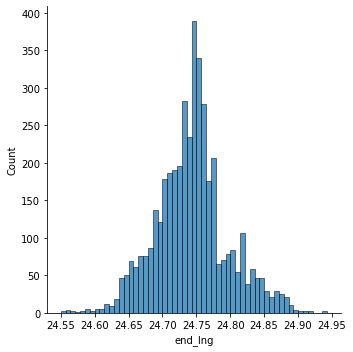

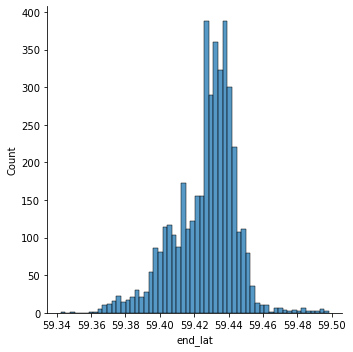

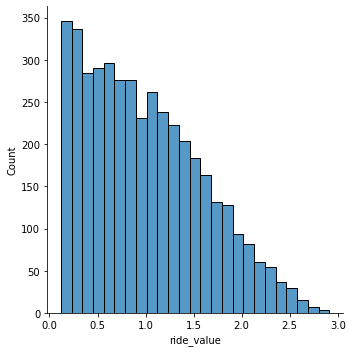

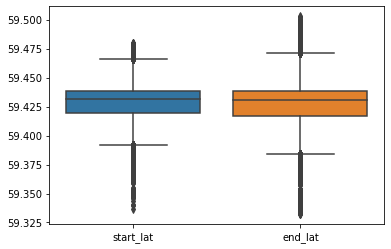

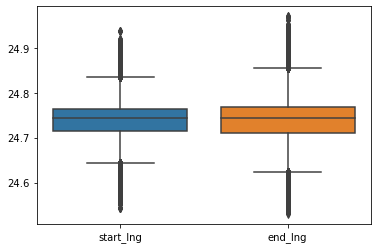

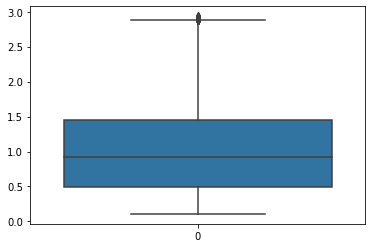

In [62]:
CONTAMINATION = 0.07
ISOLATION_COLS = ['start_lat', 'start_lng',
                  'end_lat', 'end_lng',
                  'ride_value']
isolation_model = IsolationForest(contamination=CONTAMINATION, n_jobs=-1)
preds = isolation_model.fit_predict(train[ISOLATION_COLS])
train_isolation = train.loc[preds != -1, :].reset_index(drop=True)

train_isolation_sample = train_isolation.sample(frac=0.01)
sns.displot(train_isolation_sample['start_lng'])
sns.displot(train_isolation_sample['start_lat'])
sns.displot(train_isolation_sample['end_lng'])
sns.displot(train_isolation_sample['end_lat'])
sns.displot(train_isolation_sample['ride_value'])

boxplot_data(train_isolation)


## Clustering into regions

Let's clusterize points into regions by the start coordinates. Since we don't have duration of each ride, path, or length of the path, the end ride coordinates are not very informative.

Let's use OPTICS algorithm, since it doesn't have predefined number of clusters. Since the dataset is loo large, let's sample from the dataset, clusterize it, and then we can build supervised prediction model for all of the dataset.

In [63]:

X_COLS_CLUSTER = ['start_lat', 'start_lng']
FRAC = 0.002
RANDOM_STATE = 42

train = train_isolation
cluster_model = OPTICS(metric='haversine', n_jobs=-1, eps=0.0001, min_samples=13)
coords = np.radians(train[['start_lat', 'start_lng']])
cluster_model.fit(coords.sample(frac=FRAC, random_state=RANDOM_STATE))

np.unique(cluster_model.labels_)

idx = train.sample(frac=FRAC, random_state=RANDOM_STATE).index
train.loc[idx, 'cluster'] = cluster_model.labels_
dataset = train.loc[idx]
dataset = dataset[(dataset['cluster'] != -1) & ~dataset['cluster'].isna()]

cluster_train, cluster_val = train_test_split(dataset)

kneighbors_model = KNeighborsClassifier(metric='haversine')
kneighbors_model.fit(np.radians(cluster_train[X_COLS_CLUSTER]), cluster_train['cluster'])
y_pred = kneighbors_model.predict(np.radians(cluster_val[X_COLS_CLUSTER]))
print(accuracy_score(cluster_val['cluster'], y_pred))

0.9743589743589743


### Visualization of clustering

Here's how clustering looks for the sample data:

<AxesSubplot:>

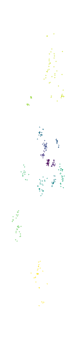

In [64]:
gdf = gpd.GeoDataFrame(
    dataset, 
    geometry=gpd.points_from_xy(dataset.start_lat, dataset.start_lng),
)
gplt.pointplot(gdf, s=0.2, hue=dataset.cluster)


And here how clustering looks for the larger sample of train dataset after classification:

<AxesSubplot:>

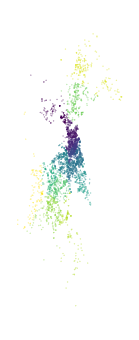

In [35]:
train_sample = train[~train.index.isin(cluster_train.index)].sample(frac=0.01)

train_sample['cluster'] = kneighbors_model.predict(np.radians(train_sample[['start_lat', 'start_lng']]))
# %%
gdf = gpd.GeoDataFrame(
    train_sample, 
    geometry=gpd.points_from_xy(train_sample.start_lat, train_sample.start_lng),
)
gplt.pointplot(gdf, s=0.2, hue=train_sample.cluster)

In [36]:

train.loc[:, 'cluster'] = kneighbors_model.predict(np.radians(train[X_COLS_CLUSTER]))

Distribution of rides per cluster:

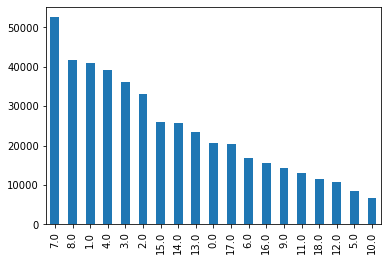

In [37]:
train['cluster'].value_counts().plot.bar()


## Value and demand calculation per cluster 

In [ ]:

train.loc[:, 'demand'] = 0
train_data = train.set_index(
    'start_time').groupby(
        'cluster').resample(
            '1H').agg(
                {"demand": 'count',
                 "ride_value": 'sum'})


In [38]:
train_data = train_data.reset_index()
train_data = train_data.set_index('start_time')

In [39]:
train_large_cluster = train_data[train_data.cluster == 8]
train_median_cluster = train_data[train_data.cluster == 6]
train_small_cluster = train_data[train_data.cluster == 10]


Let's look at the distridution of value and demand, their correlation and autocorrelation of value per largest, median and smallest cluster.

Since value and demand are correlated, we can treat value of cluster as weighted demand. Then, it will be typical demand per region of taxi rides prediction problem.

Since value is autocorrelated we can use ARIMA kind of model for the baseline. As decomposition shows, the data is seasonal, probably has a trend.

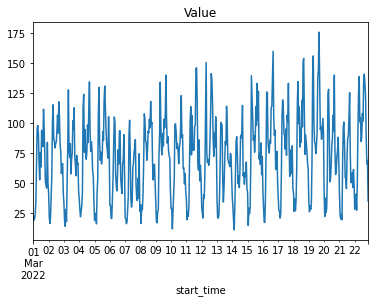

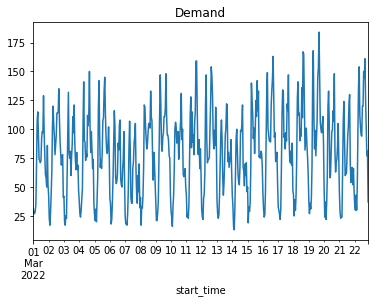

<Figure size 432x288 with 0 Axes>

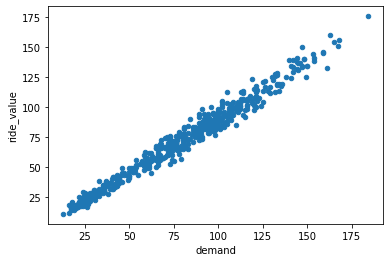

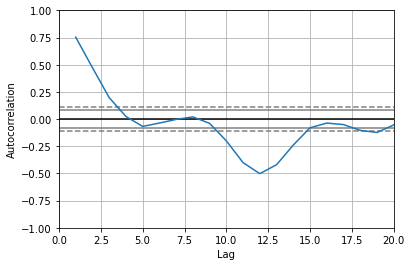

<Figure size 432x288 with 0 Axes>

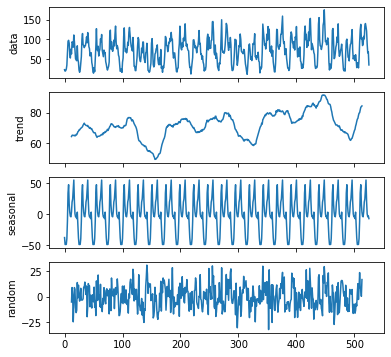

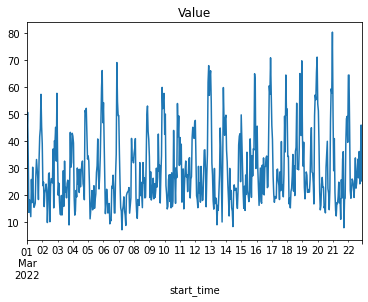

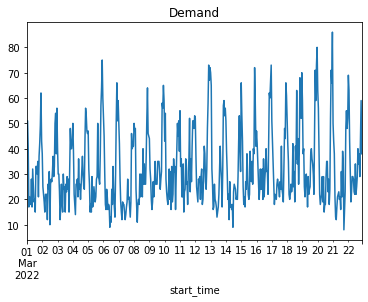

<Figure size 432x288 with 0 Axes>

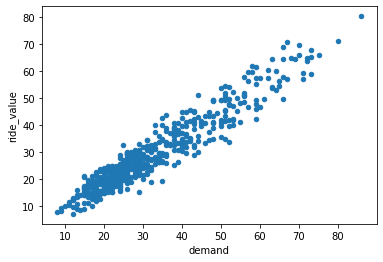

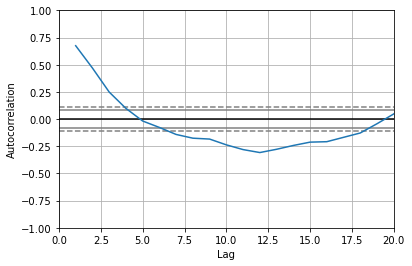

<Figure size 432x288 with 0 Axes>

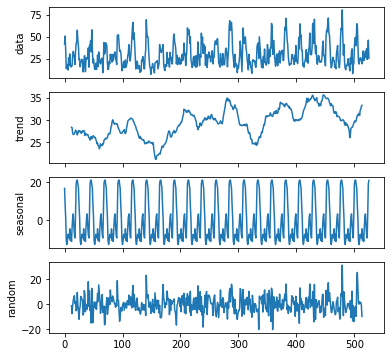

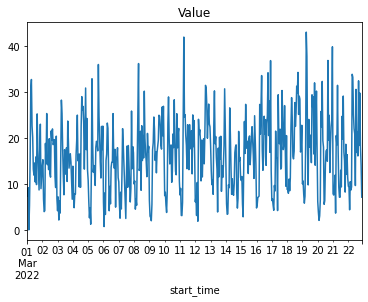

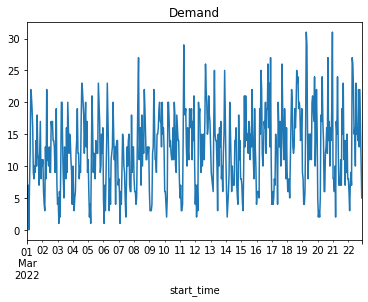

<Figure size 432x288 with 0 Axes>

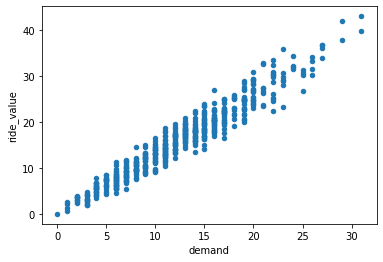

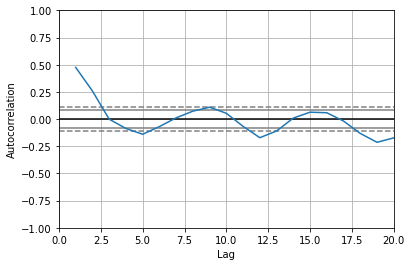

<Figure size 432x288 with 0 Axes>

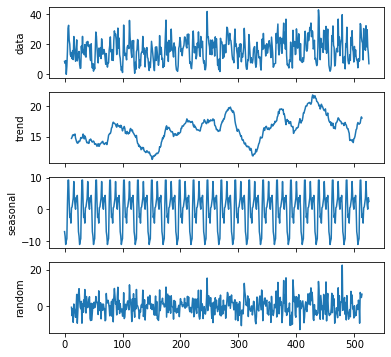

In [40]:
def plot_cluster(cluster):
  plt.figure()
  cluster['ride_value'].plot(title='Value')
  plt.figure()
  cluster['demand'].plot(title='Demand')
  plt.figure()
  cluster[['demand', 'ride_value']].plot('demand', 'ride_value', kind='scatter')
  plt.figure()
  autocorrelation_plot(cluster['ride_value']).set_xlim([0, 20])
  plt.figure()
  decomposed = decompose(cluster['ride_value'].to_numpy(), 'additive', m=24)
  figure_kwargs = {'figsize': (6, 6)} 
  decomposed_plot(decomposed,  figure_kwargs=figure_kwargs,)

plot_cluster(train_large_cluster)
plot_cluster(train_median_cluster)
plot_cluster(train_small_cluster)

## Model training

Let's process validation dataset similarly to the train dataset:

In [ ]:

def full_preprocess(df, isolation_model, kneighbors_model):
  df = initial_preprocess(df)  

  preds = isolation_model.predict(df[ISOLATION_COLS])
  df = df.loc[preds != -1, :].reset_index()
  df.loc[:, 'cluster'] = kneighbors_model.predict(np.radians(df[X_COLS_CLUSTER]))
  dataset = df.set_index(
    'start_time').groupby(
        'cluster').resample(
            '1H').agg(            
              {"ride_value": 'sum'})
  
  return dataset.reset_index().set_index('start_time')

preprocess_params = {
  'df': val,
  'isolation_model': isolation_model,
  'kneighbors_model': kneighbors_model}

val_processed = full_preprocess(**preprocess_params)

In order not to select parameters and not to check for stationarity let's use autoarima model:

In [50]:
def train_cluster(train_cluster, val_cluster):  
  model = pm.auto_arima(train_cluster, start_p=0,
                        start_q=0, start_P=0,
                        start_Q=0, max_d=2,
                        max_q=2, max_p=2, 
                        max_P=2, max_Q=2, 
                        max_D=2, seasonal=True,
                        stepwise=True, suppress_warnings=True, 
                        D=None, error_action='ignore',
                        m=24)

  preds, conf_int = model.predict(n_periods=val_cluster.shape[0],  return_conf_int=True)
  return model, preds

In [51]:
def plot_results(test, preds):
  pyplot.plot(test)
  preds = pd.Series(preds, index=test.index)
  pyplot.plot(preds, color='red')
  pyplot.show()

We also need to check how model is performing in forecasting one step ahead, which is how it'll be used in A/B testing.

The following code is taked from the documentation here: https://alkaline-ml.com/pmdarima/index.html

In [52]:
def forecast_one_step(model):
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])


def full_one_step(val, model):
  forecasts = []
  confidence_intervals = []
  for new_ob in val:
    fc, conf = forecast_one_step(model)
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)
  print(f"Root mean squared error: {np.sqrt(mean_squared_error(val, forecasts))}")
  return forecasts, confidence_intervals


Let's train with separate model per cluster:

Validation RMSE: 40.684 for cluster 0


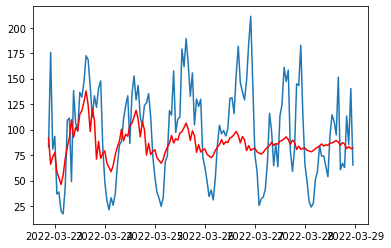

Root mean squared error: 26.536182194139254
One step validation RMSE: 26.536 for cluster 0


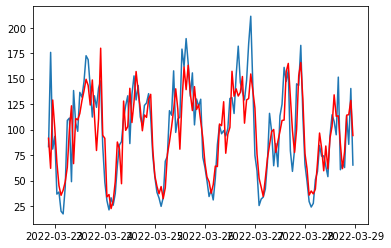

Validation RMSE: 24.437 for cluster 1


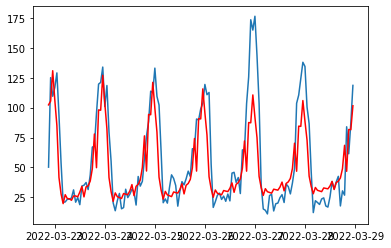

Root mean squared error: 17.655793684760166
One step validation RMSE: 17.656 for cluster 1


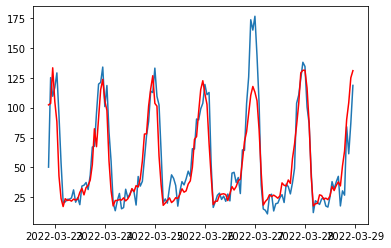

Validation RMSE: 36.055 for cluster 2


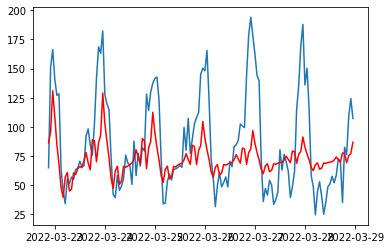

Root mean squared error: 18.66097084736385
One step validation RMSE: 18.661 for cluster 2


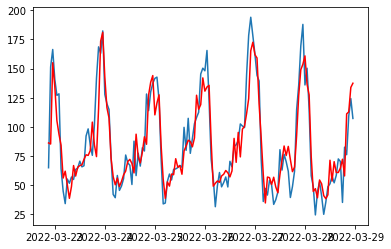

Validation RMSE: 33.600 for cluster 3


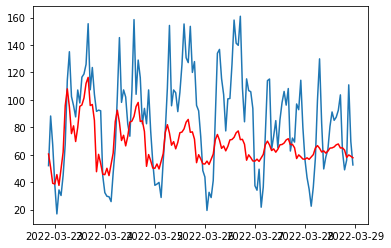

Root mean squared error: 20.31253951799849
One step validation RMSE: 20.313 for cluster 3


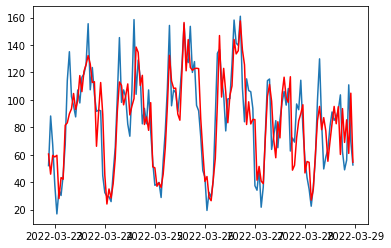

Validation RMSE: 28.827 for cluster 4


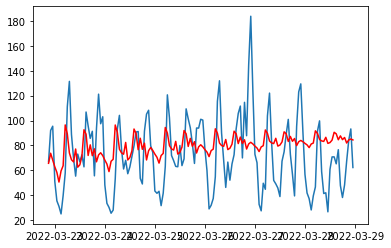

Root mean squared error: 18.640199088234603
One step validation RMSE: 18.640 for cluster 4


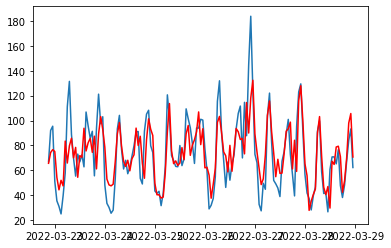

Validation RMSE: 22.608 for cluster 5


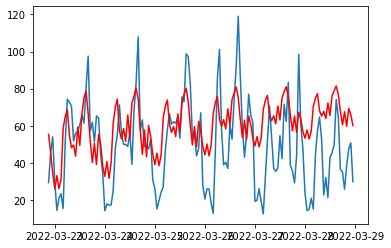

Root mean squared error: 14.167143076489198
One step validation RMSE: 14.167 for cluster 5


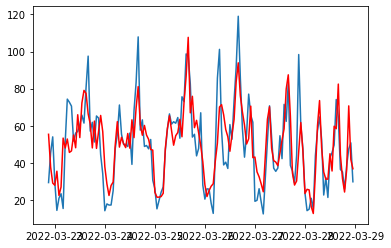

Validation RMSE: 12.563 for cluster 6


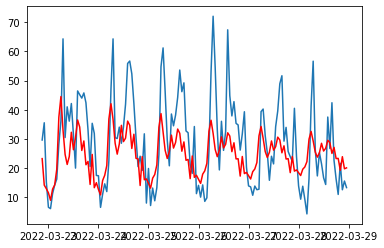

Root mean squared error: 8.673948799378225
One step validation RMSE: 8.674 for cluster 6


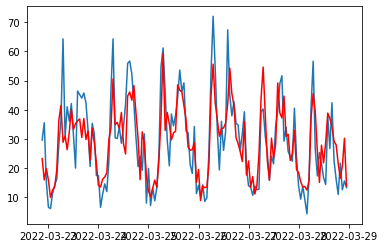

Validation RMSE: 27.165 for cluster 7


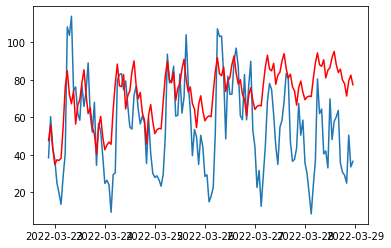

Root mean squared error: 13.979795203665185
One step validation RMSE: 13.980 for cluster 7


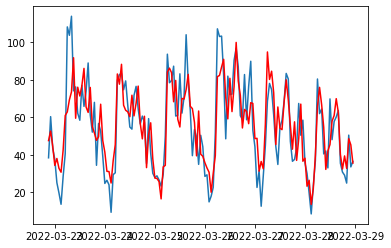

Validation RMSE: 18.289 for cluster 8


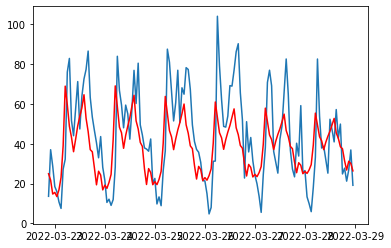

Root mean squared error: 11.545203986923688
One step validation RMSE: 11.545 for cluster 8


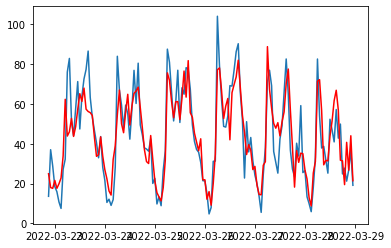

Validation RMSE: 29.751 for cluster 9


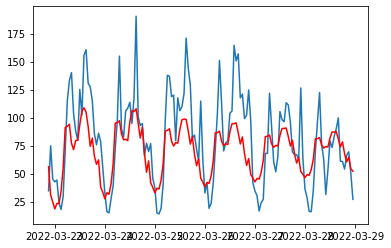

Root mean squared error: 20.6801019347145
One step validation RMSE: 20.680 for cluster 9


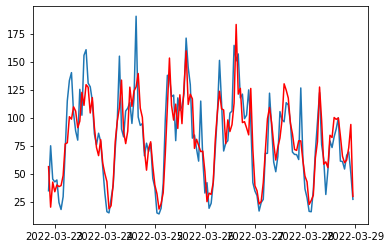

Validation RMSE: 63.354 for cluster 10


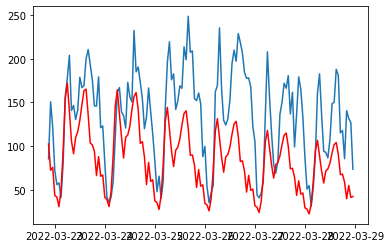

Root mean squared error: 25.706113115501065
One step validation RMSE: 25.706 for cluster 10


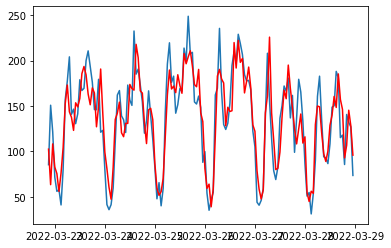

Validation RMSE: 17.179 for cluster 11


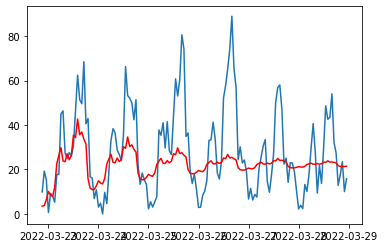

Root mean squared error: 9.959628334132935
One step validation RMSE: 9.960 for cluster 11


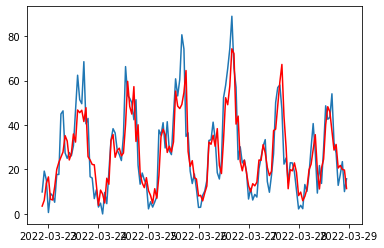

Validation RMSE: 21.744 for cluster 12


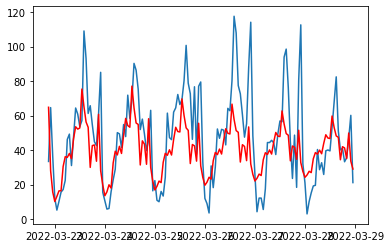

Root mean squared error: 13.899545902881881
One step validation RMSE: 13.900 for cluster 12


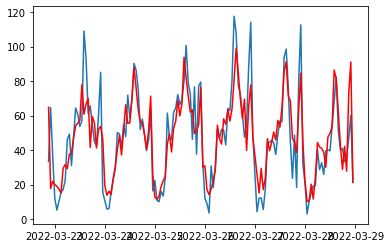

Validation RMSE: 32.543 for cluster 13


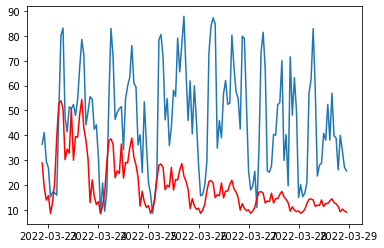

Root mean squared error: 14.49784884462812
One step validation RMSE: 14.498 for cluster 13


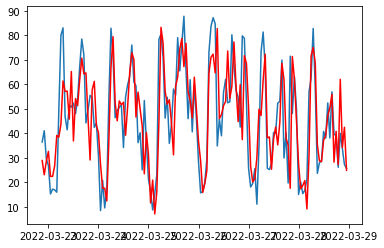

Validation RMSE: 23.422 for cluster 14


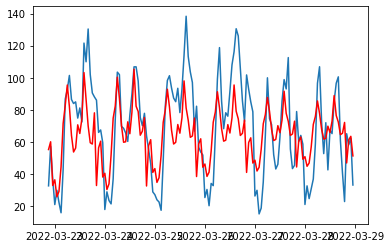

Root mean squared error: 14.434780408638037
One step validation RMSE: 14.435 for cluster 14


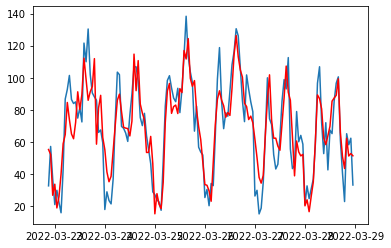

Validation RMSE: 60.944 for cluster 15


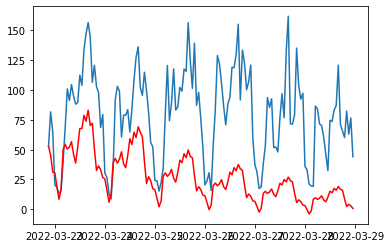

Root mean squared error: 20.664998889132423
One step validation RMSE: 20.665 for cluster 15


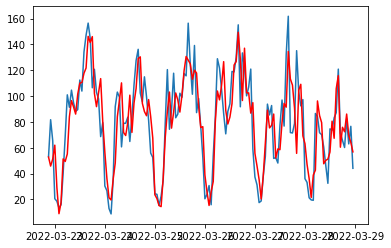

Validation RMSE: 29.191 for cluster 16


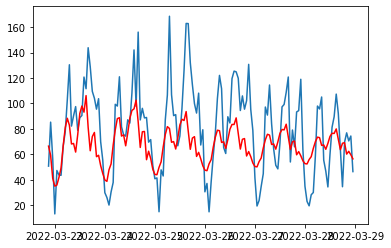

Root mean squared error: 19.474565621958046
One step validation RMSE: 19.475 for cluster 16


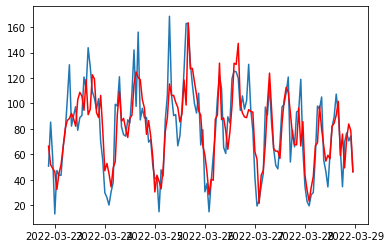

Mean validation RMSE: 30.727
Mean one step validation RMSE: 17.029


In [54]:
rmse_errors = []
rmse_step_errors = []

for cluster in train_data['cluster'].unique():
  training_cluster = train_data[train_data['cluster'] == cluster]['ride_value']
  val_cluster = val_processed[val_processed['cluster'] == cluster]['ride_value']

  model, preds = train_cluster(training_cluster, val_cluster)
  with open(f'arima_{cluster}.pkl', 'wb') as pkl:
    pickle.dump(model, pkl)

  rmse = np.sqrt(mean_squared_error(val_cluster, preds))
  rmse_errors.append(rmse)
  print("Validation RMSE: %.3f for cluster %.0f" % (rmse, cluster))
  plot_results(val_cluster, preds)

  forecasts, _ = full_one_step(val_cluster, model)
  rmse_step = np.sqrt(mean_squared_error(val_cluster, forecasts))
  rmse_step_errors.append(rmse_step)
  print("One step validation RMSE: %.3f for cluster %.0f" % (rmse_step, cluster))
  plot_results(val_cluster, forecasts)
mean_rmse = np.mean(rmse_errors)
mean_step_rmse = np.mean(rmse_step_errors)
print("Mean validation RMSE: %.3f" % mean_rmse)
print("Mean one step validation RMSE: %.3f" % mean_step_rmse)


So, the mean validation RMSE for all the regions is 30.727, and for one step prediction it's 17.029. Let's check residuals for normality with Shapiro test in order to be sure if it was valid to use MSE for optimization:

In [60]:
for cluster in train_data['cluster'].unique():
    with open(f'arima_{cluster}.pkl', 'rb') as pkl:
        model = pickle.load(pkl)
    residuals = model.resid()
    stats, p = shapiro(residuals)
    print('Stats=%.3f, p=%.3f' % (stats, p))
    

Stats=0.991, p=0.003
Stats=0.942, p=0.000
Stats=0.954, p=0.000
Stats=0.990, p=0.001
Stats=0.988, p=0.000
Stats=0.994, p=0.049
Stats=0.983, p=0.000
Stats=0.989, p=0.000
Stats=0.988, p=0.000
Stats=0.982, p=0.000
Stats=0.991, p=0.003
Stats=0.988, p=0.000
Stats=0.996, p=0.298
Stats=0.996, p=0.138
Stats=0.995, p=0.095
Stats=0.995, p=0.101
Stats=0.996, p=0.183


## A/B testing and further ideas

Since region value and demand are correlated we treated value as weighted demand. The testing can be done by comparing so called reactive strategy with no relocation of taxis and proactive strategy with our baseline model. This is based on the paper (https://link.springer.com/content/pdf/10.1007/s11116-020-10116-w.pdf)

According to the paper it will be demand anticipation strategy, only in our case it's value anticipation. Out of R regions we can choose K with the highest values for each step (hour in our case). All idle taxis will be relocated to a nearest region out of K.

The testing can be done in a week by randomly choosing taxis for reactive and proactive strategies testing. The metric of the testing will be average income per driver. We can use Welch's t-test.

As for the additional data that could help improve the model, it'd nice to have area of Bolt taxi covering of Tallinn and also map of Tallinn's districts in order to better remove outliers and to better split the maps into regions. Distance of the ride and duration would also help because this way we can predict not only demand, but also supply. It would be also good to have the time of the request for the ride. This way the demand can be better predicted. Probably, it would be better to use net realizable value of each ride instead of monetary value.

## References
https://link.springer.com/content/pdf/10.1007/s11116-020-10116-w.pdf

https://alkaline-ml.com/pmdarima/index.html